# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construiremos un modelo para realizar dicha predicción, nuestro objetivo es que la métrica RECM en el conjunto de prueba no debe ser superior a 48 taxis por hora.

## Preparación

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [2]:
df = pd.read_csv('/datasets/taxi.csv', parse_dates=True, index_col=[0]).sort_index()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


## Análisis

In [5]:
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<AxesSubplot:xlabel='datetime'>

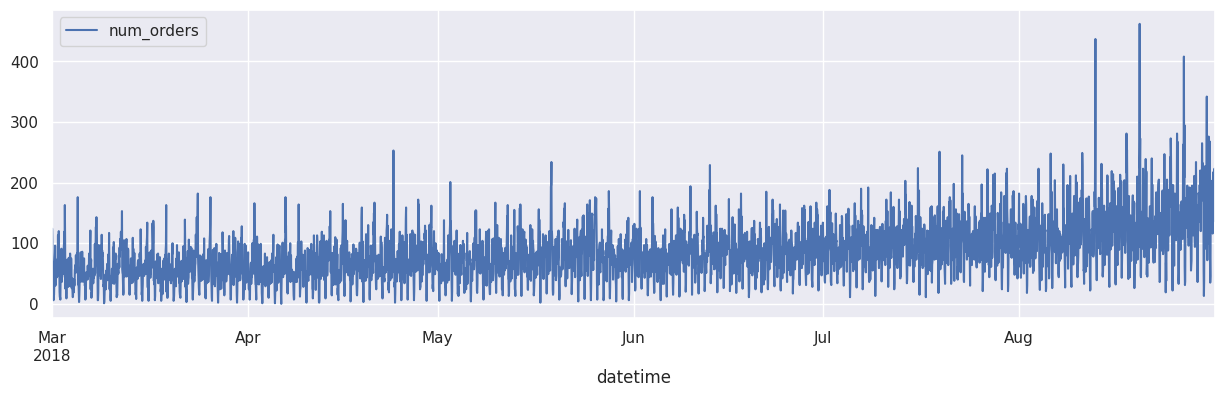

In [6]:
fix, ax = plt.subplots(figsize=(15,4))
df.plot(ax=ax)

<AxesSubplot:>

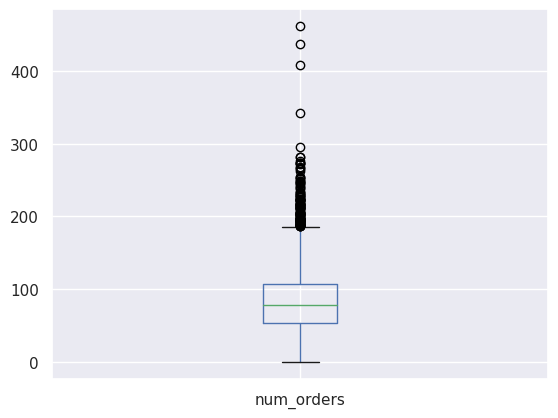

In [7]:
df.plot.box()

In [8]:
df_day = df.resample('1D').sum()
df_day.head()

,num_orders
datetime,
2018-03-01,1364
2018-03-02,1506
2018-03-03,1290
2018-03-04,1141
2018-03-05,1259


<AxesSubplot:xlabel='datetime'>

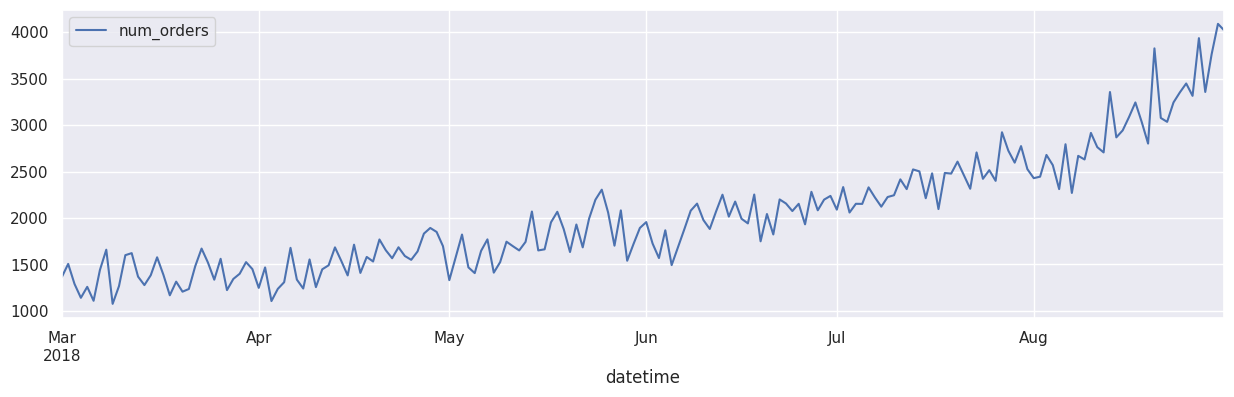

In [9]:
fix, ax = plt.subplots(figsize=(15,4))
df_day.plot(ax=ax)

<AxesSubplot:>

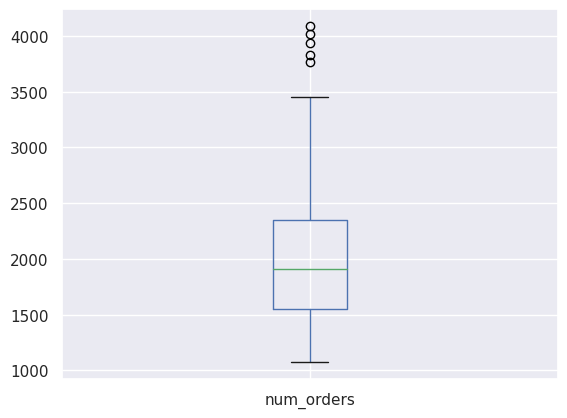

In [10]:
df_day.plot.box()

## Formación

### Creación de características.

In [11]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['week'] = data.index.week
    data['month'] = data.index.month
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(df, 3, 2)
df.head(30)


,num_orders,hour,day,dayofweek,week,month,lag_1,lag_2,lag_3,rolling_mean
datetime,,,,,,,,,,
2018-03-01 00:00:00,124,0,1,3,9,3,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,1,3,9,3,124.0,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,1,3,9,3,85.0,124.0,NaN,104.5
2018-03-01 03:00:00,66,3,1,3,9,3,71.0,85.0,124.0,78.0
2018-03-01 04:00:00,43,4,1,3,9,3,66.0,71.0,85.0,68.5
2018-03-01 05:00:00,6,5,1,3,9,3,43.0,66.0,71.0,54.5
2018-03-01 06:00:00,12,6,1,3,9,3,6.0,43.0,66.0,24.5
2018-03-01 07:00:00,15,7,1,3,9,3,12.0,6.0,43.0,9.0
2018-03-01 08:00:00,34,8,1,3,9,3,15.0,12.0,6.0,13.5


### Separación de datasets de entrenamiento y prueba.

In [12]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)

print(train.index.min(), train.index.max(), train.shape)
print(test.index.min(), test.index.max(), test.shape)

2018-03-01 00:00:00 2018-08-13 13:00:00 (3974, 10)
2018-08-13 14:00:00 2018-08-31 23:00:00 (442, 10)


In [13]:
train = train.dropna()

train.shape

(3971, 10)

In [14]:
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']

features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

In [15]:
features_train

,hour,day,dayofweek,week,month,lag_1,lag_2,lag_3,rolling_mean
datetime,,,,,,,,,
2018-03-01 03:00:00,3,1,3,9,3,71.0,85.0,124.0,78.0
2018-03-01 04:00:00,4,1,3,9,3,66.0,71.0,85.0,68.5
2018-03-01 05:00:00,5,1,3,9,3,43.0,66.0,71.0,54.5
2018-03-01 06:00:00,6,1,3,9,3,6.0,43.0,66.0,24.5
2018-03-01 07:00:00,7,1,3,9,3,12.0,6.0,43.0,9.0
...,...,...,...,...,...,...,...,...,...
2018-08-13 09:00:00,9,13,0,33,8,91.0,39.0,66.0,65.0
2018-08-13 10:00:00,10,13,0,33,8,137.0,91.0,39.0,114.0
2018-08-13 11:00:00,11,13,0,33,8,156.0,137.0,91.0,146.5


 ### Escalado y estandarización de características.
 ---
Debido a las distintos valores que nuestras columnas tienen nuestro modelo se podría confundir a la hora de entrenarlo, por ello vamos a estandarizar todas las características para prevenir que se asignen pesos y afecte nuestras predicciones. 

In [16]:
pd.options.mode.chained_assignment = None
columns = features_train.columns

scaler = StandardScaler().fit(features_train[columns])

features_train[columns] = scaler.transform(features_train[columns])
features_test[columns] = scaler.transform(features_test[columns])

features_train.head()

,hour,day,dayofweek,week,month,lag_1,lag_2,lag_3,rolling_mean
datetime,,,,,,,,,
2018-03-01 03:00:00,-1.227447,-1.592432,-0.01283,-1.722211,-1.412939,-0.187932,0.174161,1.183080,-0.007790
2018-03-01 04:00:00,-1.082877,-1.592432,-0.01283,-1.722211,-1.412939,-0.317234,-0.187889,0.174324,-0.285686
2018-03-01 05:00:00,-0.938306,-1.592432,-0.01283,-1.722211,-1.412939,-0.912023,-0.317192,-0.187794,-0.695217
2018-03-01 06:00:00,-0.793736,-1.592432,-0.01283,-1.722211,-1.412939,-1.868857,-0.911988,-0.317122,-1.572782
2018-03-01 07:00:00,-0.649165,-1.592432,-0.01283,-1.722211,-1.412939,-1.713694,-1.868834,-0.912029,-2.026192


### Prueba de cordura.
---
Vamos a realizar un pronóstico que nos servira como un punto de referencia útil. Recordemos que nuestra meta es que la métrica RECM en el conjunto de prueba no debe ser superior a 48.

In [17]:
print('Promedio de pedidos por hora de taxis en el aeropuerto:', target_test.mean())
pred_previous = target_test.shift(fill_value=train.iloc[-1, 0])

print('RECM:', mean_squared_error(target_test, pred_previous, squared=False))

Promedio de pedidos por hora de taxis en el aeropuerto: 139.55656108597285
RECM: 58.856486242815066


## Desarrollo, entrenamiento de modelos y prueba

### Modelo 1: Regresion lineal.

In [18]:
%%time
model_1 = LinearRegression().fit(features_train, target_train)
predictions_train = model_1.predict(features_train)
predictions_test = model_1.predict(features_test)

print("RECM para el conjunto de entrenamiento:", mean_squared_error(predictions_train,target_train, squared=False))
print("RECM para el conjunto de prueba:", mean_squared_error(predictions_test, target_test, squared=False))

RECM para el conjunto de entrenamiento: 30.557889065739936
RECM para el conjunto de prueba: 52.58748411954095
CPU times: user 12.5 ms, sys: 35.5 ms, total: 48 ms
Wall time: 16.3 ms


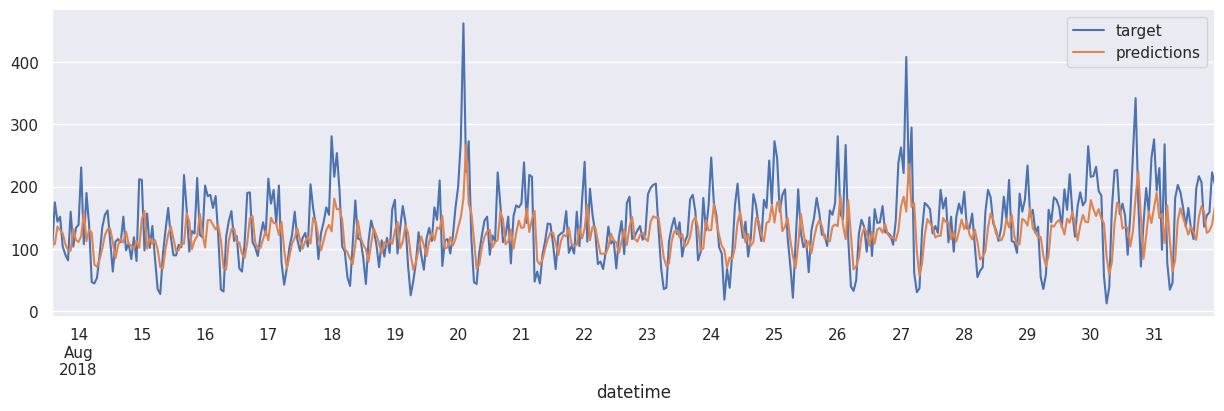

In [19]:
predictions_test = pd.Series(predictions_test, index=target_test.index)

fix, ax = plt.subplots(figsize=(15,4))

target_test.plot(ax=ax)
predictions_test.plot(ax=ax)

plt.legend(["target", "predictions"])

### Modelo 2: LightGBM.

In [20]:
%%time
model_2 = LGBMRegressor(metric='rmse').fit(features_train, target_train)
predictions_train = model_2.predict(features_train)
predictions_test = model_2.predict(features_test)

print("RECM para el conjunto de entrenamiento:", mean_squared_error(predictions_train,target_train, squared=False))
print("RECM para el conjunto de prueba:", mean_squared_error(predictions_test, target_test, squared=False))

RECM para el conjunto de entrenamiento: 15.26396600567044
RECM para el conjunto de prueba: 44.731674679370634
CPU times: user 528 ms, sys: 23.4 ms, total: 551 ms
Wall time: 533 ms


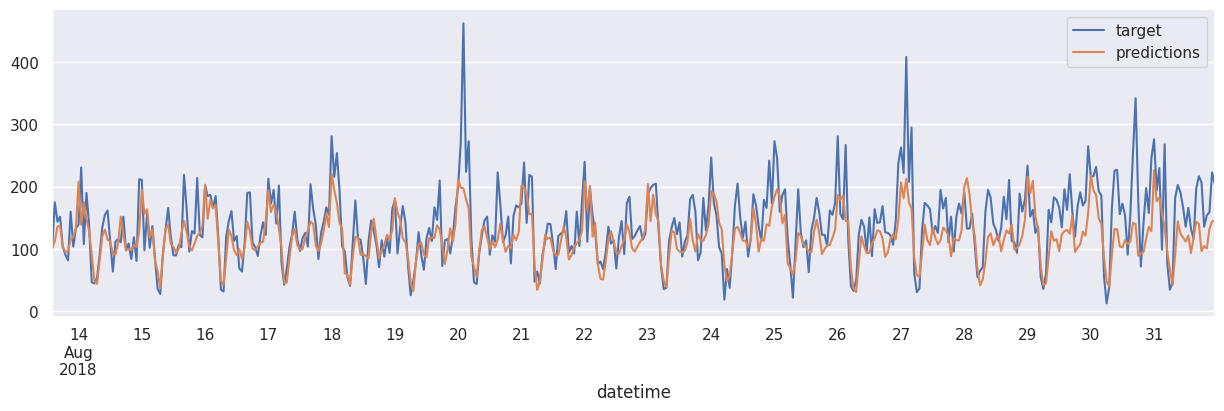

In [21]:
predictions_test = pd.Series(predictions_test, index=target_test.index)

fix, ax = plt.subplots(figsize=(15,4))

target_test.plot(ax=ax)
predictions_test.plot(ax=ax)

plt.legend(["target", "predictions"])

### Model 3: CatBoost.

In [22]:
#model = CatBoostRegressor()
#parameters = {'depth' : [6,8,10], 'learning_rate':[0.01, 0.05, 0.1], 'iterations':[30, 50, 100], 'loss_function':['RMSE']}

#grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 2, n_jobs=-1).fit(features_train, target_train)

#print('Mejores parametros: ', grid.best_params_)

In [23]:
%%time
model_3 = CatBoostRegressor(iterations=100,
                            learning_rate=0.1,
                            depth=6,
                            loss_function='RMSE',
                            verbose=20).fit(features_train, target_train)

predictions_train = model_3.predict(features_train)
predictions_test = model_3.predict(features_test)

print("RECM para el conjunto de entrenamiento:", mean_squared_error(predictions_train,target_train, squared=False))
print("RECM para el conjunto de prueba:", mean_squared_error(predictions_test, target_test, squared=False))

0:	learn: 36.7610857	total: 49.7ms	remaining: 4.92s
20:	learn: 24.6914423	total: 104ms	remaining: 390ms
40:	learn: 22.9807778	total: 148ms	remaining: 213ms
60:	learn: 21.6241610	total: 193ms	remaining: 123ms
80:	learn: 20.7124419	total: 241ms	remaining: 56.4ms
99:	learn: 19.9979650	total: 289ms	remaining: 0us
RECM para el conjunto de entrenamiento: 19.997964981608572
RECM para el conjunto de prueba: 45.89380827571594
CPU times: user 264 ms, sys: 6.88 ms, total: 271 ms
Wall time: 411 ms


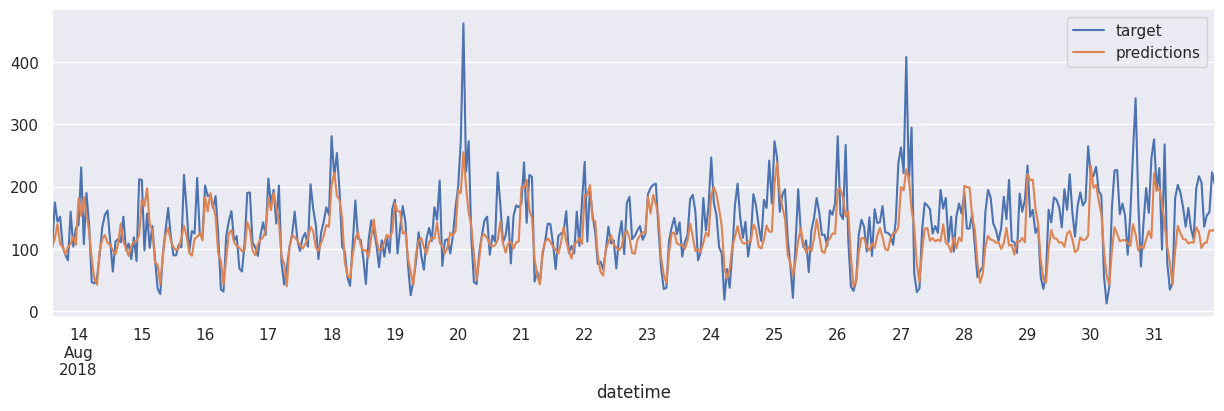

In [24]:
predictions_test = pd.Series(predictions_test, index=target_test.index)

fix, ax = plt.subplots(figsize=(15,4))

target_test.plot(ax=ax)
predictions_test.plot(ax=ax)

plt.legend(["target", "predictions"])

# Conclusion
---
En nuestro mejor modelo obtuvimos un RMSE de 44 pedidos por hora, valor considerable ya que en promedio se piden 140 taxis por hora, se puede interpretar que el error estándar es aproximadamente el 31% del promedio de pedidos. Este es un valor moderado y puede ser considerado aceptable dependiendo del contexto y los objetivos del negocio.
